# Comp Dist Architecture Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-comp-dist-fix-params-and-seed',))]

In [5]:
len(experiment_rows)

120

In [6]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_comp_unit1_only':
        arch = 'U1'
    elif args['arch'] == 'mpcnn_comp_unit2_only':
        arch = 'U2'
    elif args['arch'] == 'mpcnn_comp_horiz_only':
        arch = 'Horiz'
    elif args['arch'] == 'mpcnn_comp_vert_only':
        arch = 'Vert'
    elif args['arch'] == 'mpcnn_comp_vert_holistic_only':
        arch = 'Vert. Holistic'
    elif args['arch'] == 'mpcnn_comp_cosine':
        arch = 'Cosine'
    elif args['arch'] == 'mpcnn_comp_euclidean':
        arch = 'Euclidean'
    elif args['arch'] == 'mpcnn_comp_abs_diff':
        arch = 'AbsDiff'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [7]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [8]:
trecqa.head(8)

,arch,dataset,metric_name,metric_val,seed,split
0,MP-CNN,trecqa,MAP,0.8224,16630,dev
1,MP-CNN,trecqa,MRR,0.8066,16630,dev
2,MP-CNN,trecqa,MAP,0.8158,16630,test
3,MP-CNN,trecqa,MRR,0.8062,16630,test
4,Cosine,trecqa,MAP,0.7905,16630,dev
5,Cosine,trecqa,MRR,0.8470,16630,dev
6,Cosine,trecqa,MAP,0.7561,16630,test
7,Cosine,trecqa,MRR,0.8127,16630,test


In [9]:
# archs = ['MP-CNN', 'Horiz', 'Vert', 'Vert. Holistic']
archs = ['MP-CNN', 'Cosine', 'Euclidean', 'AbsDiff']
def compare_change_to_baseline(df, metric):
    changes = {'MP-CNN': 'baseline'}
    config_ids = df['seed'].unique()
    for arch in archs:
        if arch == 'MP-CNN':
            continue

        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch} comparison only')
        print(f'Median of {metric} change compared with MP-CNN baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with MP-CNN baseline: {np.mean(diffs):.4f}')
        diff = np.median(diffs)
        changes[arch] = f'+{diff:.4f}' if diff > 0 else f'{diff:.4f}'
    
    return changes

## TrecQA

In [10]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [11]:
trec_map_intervals = {}
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.7752, 0.8020)
Cosine: (0.7486, 0.7926)
Euclidean: (0.7473, 0.7607)
AbsDiff: (0.7686, 0.7875)


In [12]:
trec_mrr_intervals = {}
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.8169, 0.8406)
Cosine: (0.5808, 0.8735)
Euclidean: (0.8111, 0.8367)
AbsDiff: (0.8159, 0.8403)


In [13]:
trec_map_delta = compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Cosine comparison only
Median of MAP change compared with MP-CNN baseline: -0.0277
Mean of MAP change compared with MP-CNN baseline: -0.0180
Architecture: Euclidean comparison only
Median of MAP change compared with MP-CNN baseline: -0.0386
Mean of MAP change compared with MP-CNN baseline: -0.0346
Architecture: AbsDiff comparison only
Median of MAP change compared with MP-CNN baseline: -0.0116
Mean of MAP change compared with MP-CNN baseline: -0.0106


In [14]:
trec_map_vs_archs_test[trec_map_vs_archs_test.arch == 'Horiz']

,arch,dataset,metric_name,metric_val,seed,split


In [15]:
trec_mrr_delta = compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Cosine comparison only
Median of MRR change compared with MP-CNN baseline: -0.0099
Mean of MRR change compared with MP-CNN baseline: -0.1016
Architecture: Euclidean comparison only
Median of MRR change compared with MP-CNN baseline: -0.0020
Mean of MRR change compared with MP-CNN baseline: -0.0048
Architecture: AbsDiff comparison only
Median of MRR change compared with MP-CNN baseline: -0.0033
Mean of MRR change compared with MP-CNN baseline: -0.0006


## WikiQA

In [16]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [17]:
wikiqa_map_intervals = {}
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.6538, 0.7239)
Cosine: (0.6870, 0.6990)
Euclidean: (0.6865, 0.6939)
AbsDiff: (0.6220, 0.7272)


In [18]:
wikiqa_mrr_intervals = {}
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.6607, 0.7391)
Cosine: (0.6961, 0.7101)
Euclidean: (0.6993, 0.7080)
AbsDiff: (0.6320, 0.7414)


In [19]:
wikiqa_map_delta = compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Cosine comparison only
Median of MAP change compared with MP-CNN baseline: -0.0177
Mean of MAP change compared with MP-CNN baseline: 0.0041
Architecture: Euclidean comparison only
Median of MAP change compared with MP-CNN baseline: -0.0212
Mean of MAP change compared with MP-CNN baseline: 0.0014
Architecture: AbsDiff comparison only
Median of MAP change compared with MP-CNN baseline: -0.0136
Mean of MAP change compared with MP-CNN baseline: -0.0143


In [20]:
wikiqa_mrr_delta = compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Cosine comparison only
Median of MRR change compared with MP-CNN baseline: -0.0246
Mean of MRR change compared with MP-CNN baseline: 0.0032
Architecture: Euclidean comparison only
Median of MRR change compared with MP-CNN baseline: -0.0213
Mean of MRR change compared with MP-CNN baseline: 0.0037
Architecture: AbsDiff comparison only
Median of MRR change compared with MP-CNN baseline: -0.0151
Mean of MRR change compared with MP-CNN baseline: -0.0132


## SICK

In [21]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [22]:
sick_pearson_intervals = {}
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_pearson_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.8500, 0.8746)
Cosine: (0.8351, 0.8406)
Euclidean: (0.8552, 0.8591)
AbsDiff: (0.8686, 0.8730)


In [23]:
sick_spearman_intervals = {}
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_spearman_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN: (0.8030, 0.8109)
Cosine: (0.7614, 0.7689)
Euclidean: (0.7943, 0.7996)
AbsDiff: (0.8038, 0.8113)


In [24]:
sick_pearson_delta = compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Cosine comparison only
Median of pearson change compared with MP-CNN baseline: -0.0302
Mean of pearson change compared with MP-CNN baseline: -0.0244
Architecture: Euclidean comparison only
Median of pearson change compared with MP-CNN baseline: -0.0095
Mean of pearson change compared with MP-CNN baseline: -0.0051
Architecture: AbsDiff comparison only
Median of pearson change compared with MP-CNN baseline: 0.0034
Mean of pearson change compared with MP-CNN baseline: 0.0085


In [25]:
sick_spearman_delta = compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Cosine comparison only
Median of spearman change compared with MP-CNN baseline: -0.0407
Mean of spearman change compared with MP-CNN baseline: -0.0418
Architecture: Euclidean comparison only
Median of spearman change compared with MP-CNN baseline: -0.0105
Mean of spearman change compared with MP-CNN baseline: -0.0100
Architecture: AbsDiff comparison only
Median of spearman change compared with MP-CNN baseline: 0.0007
Mean of spearman change compared with MP-CNN baseline: 0.0006


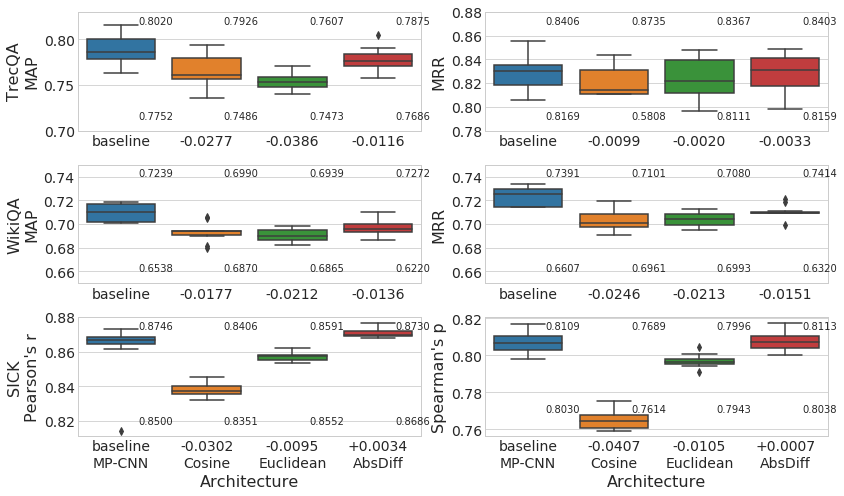

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 7)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.boxplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('TrecQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.7, 0.83))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_map_intervals[a][1])

ax = plt.subplot(322)
sns.boxplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.78, 0.88))
ax.xaxis.set_ticklabels([trec_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_mrr_intervals[a][1])

ax = plt.subplot(323)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('WikiQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.65, 0.75))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][1])

ax = plt.subplot(324)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.ylim((0.65, 0.75))
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][1])

ax = plt.subplot(325)
sns.boxplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("SICK\nPearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([sick_pearson_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_pearson_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_pearson_intervals[a][1])

ax = plt.subplot(326)
sns.boxplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([sick_spearman_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.2*(ylim[1] - ylim[0]), sick_spearman_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_spearman_intervals[a][1])
plt.tight_layout()
# plt.subplots_adjust(top=0.8, hspace=0.2)
plt.savefig('comp_unit_arch_violin.pdf')